In [1]:
from metrics import *

In [2]:
exp = "normal"
data_path = f'../data/{exp}/data/'
results_path = f'../data/{exp}/results/'
# Define  length of test data
n_test = 250

In [3]:
# Prepare dataframe
models = ["brown", "powexp"]
metrics = ["MSE_r", "MSE_s", "MSE_ext", "IS_r", "IS_s", "IIS", "KL", "ES"]
results = pd.DataFrame("-", index = pd.MultiIndex.from_product([models, metrics]), columns = ["PL", "CNN", "ABC", "CNN_ES"])
results

PL CNN ABC CNN_ES
brown  MSE_r    -   -   -      -
       MSE_s    -   -   -      -
       MSE_ext  -   -   -      -
       IS_r     -   -   -      -
       IS_s     -   -   -      -
       IIS      -   -   -      -
       KL       -   -   -      -
       ES       -   -   -      -
powexp MSE_r    -   -   -      -
       MSE_s    -   -   -      -
       MSE_ext  -   -   -      -
       IS_r     -   -   -      -
       IS_s     -   -   -      -
       IIS      -   -   -      -
       KL       -   -   -      -
       ES       -   -   -      -

# Compare Metrics

In [21]:
def fill_metrics(results, model, true_parameters, pl, abc, cnn, cnn_es, alpha = 0.05, model2 = None):
    #Get mean prediction
    abc_mean = np.mean(abc, axis = 2)
    cnn_es_mean = np.mean(cnn_es, axis = 2)
    # PL
    mse = get_mse(true_parameters, pl, sd = True)
    imse = get_integrated_error(model, true = true_parameters, estimate = pl, sd = True, model2 = model2)
    results.loc[(model, "MSE_r"), "PL"] = f"{mse[0][0]:.4f} ({mse[1][0]:.2f})"
    results.loc[(model, "MSE_s"), "PL"] = f"{mse[0][1]:.4f} ({mse[1][1]:.2f})"
    results.loc[(model, "MSE_ext"), "PL"] = f"{imse[0]:.4f} ({imse[1]:.2f})"

    # CNN 
    mse = get_mse(true_parameters, cnn, sd = True)
    imse = get_integrated_error(model, true = true_parameters, estimate = cnn, sd = True, model2 = model2)
    results.loc[(model, "MSE_r"), "CNN"] = f"{mse[0][0]:.4f} ({mse[1][0]:.2f})"
    results.loc[(model, "MSE_s"), "CNN"] = f"{mse[0][1]:.4f} ({mse[1][1]:.2f})"
    results.loc[(model, "MSE_ext"), "CNN"] = f"{imse[0]:.4f} ({imse[1]:.2f})"

    # ABC
    mse = get_mse(true_parameters, abc_mean, sd = True)
    imse = get_integrated_error(model, true = true_parameters, estimate = abc, method = "sample", sd = True, model2 = model2)
    results.loc[(model, "MSE_r"), "ABC"] = f"{mse[0][0]:.4f} ({mse[1][0]:.2f})"
    results.loc[(model, "MSE_s"), "ABC"] = f"{mse[0][1]:.4f} ({mse[1][1]:.2f})"
    results.loc[(model, "MSE_ext"), "ABC"] = f"{imse[0]:.4f} ({imse[1]:.2f})"

    quantiles = np.quantile(abc, [alpha/2,1-(alpha/2)], axis = 2)
    iscore = get_interval_score(true_parameters, alpha = alpha, q_left = quantiles[0], q_right = quantiles[1], sd = True)
    iis = get_integrated_is(model, true = true_parameters, estimate = abc, alpha = alpha, sd = True, model2 = model2)
    es = get_energy_score(true_parameters,abc, sd = True)
    results.loc[(model, "IS_r",), "ABC"] = f"{iscore[0][0]:.4f} ({iscore[1][0]:.2f})"
    results.loc[(model, "IS_s",), "ABC"] = f"{iscore[0][1]:.4f} ({iscore[1][1]:.2f})"
    results.loc[(model, ["IIS"]), "ABC"] = f"{iis[0]:.4f} ({iis[1]:.2f})"
    results.loc[(model, ["ES"]), "ABC"] = f"{es[0]:.4f} ({es[1]:.2f})"

    # CNN ES
    mse = get_mse(true_parameters, cnn_es_mean, sd = True)
    imse = get_integrated_error(model, true = true_parameters, estimate = cnn_es, method = "sample", sd = True, model2 = model2)
    results.loc[(model, "MSE_r"), "CNN_ES"] = f"{mse[0][0]:.4f} ({mse[1][0]:.2f})"
    results.loc[(model, "MSE_s"), "CNN_ES"] = f"{mse[0][1]:.4f} ({mse[1][1]:.2f})"
    results.loc[(model, "MSE_ext"), "CNN_ES"] = f"{imse[0]:.4f} ({imse[1]:.2f})"

    quantiles = np.quantile(cnn_es, [alpha/2,1-(alpha/2)], axis = 2)
    iscore = get_interval_score(true_parameters, alpha = alpha, q_left = quantiles[0], q_right = quantiles[1], sd = True)
    iis = get_integrated_is(model, true = true_parameters, estimate = cnn_es, alpha = alpha, sd = True, model2 = model2)
    es = get_energy_score(true_parameters, cnn_es, sd = True)
    results.loc[(model, "IS_r",), "CNN_ES"] = f"{iscore[0][0]:.4f} ({iscore[1][0]:.2f})"
    results.loc[(model, "IS_s",), "CNN_ES"] = f"{iscore[0][1]:.4f} ({iscore[1][1]:.2f})"
    results.loc[(model, ["IIS"]), "CNN_ES"] = f"{iis[0]:.4f} ({iis[1]:.2f})"
    results.loc[(model, ["ES"]), "CNN_ES"] = f"{es[0]:.4f} ({es[1]:.2f})"
    return results


## Normal results

In [5]:
for model in models:
    # Load true parameters
    true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
    # Load PL
    pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
    # Load ABC
    abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
    # Load normal network
    cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

    # Load energy network
    cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]
    
    results = fill_metrics(results, model, true_parameters, pl, abc, cnn, cnn_es)

c:\Users\chris\Desktop\Masterarbeit\code\evaluation\metrics.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  res = np.exp(-np.power((h / r), s))


In [6]:
results

PL            CNN              ABC  \
brown  MSE_r    3.1893 (20.44)  0.4725 (0.94)    1.6145 (1.79)   
       MSE_s     0.1256 (0.22)  0.0248 (0.04)    0.2551 (0.32)   
       MSE_ext   0.7118 (1.19)  0.1972 (0.36)    1.3252 (1.67)   
       IS_r                  -              -    4.5877 (3.03)   
       IS_s                  -              -    3.4340 (6.53)   
       IIS                   -              -  53.6913 (93.20)   
       KL                    -              -                -   
       ES                    -              -    0.8492 (0.43)   
powexp MSE_r     8.3504 (6.86)  0.6659 (1.28)    1.5956 (1.49)   
       MSE_s     0.7770 (0.85)  0.1109 (0.15)    0.1864 (0.17)   
       MSE_ext   0.1048 (0.05)  0.0098 (0.02)    0.0171 (0.01)   
       IS_r                  -              -    4.2966 (0.33)   
       IS_s                  -              -    1.4662 (0.26)   
       IIS                   -              -    2.6824 (2.21)   
       KL                    -              -                -   
       ES                    -              -    0.8154 (0.32)   

                         CNN_ES  
brown  MSE_r      0.4198 (0.74)  
       MSE_s      0.0250 (0.05)  
       MSE_ext    0.1748 (0.28)  
       IS_r       2.8093 (3.51)  
       IS_s       0.9040 (1.55)  
       IIS      11.1230 (10.65)  
       KL                     -  
       ES         0.3723 (0.28)  
powexp MSE_r      0.8964 (1.91)  
       MSE_s      0.0503 (0.08)  
       MSE_ext    0.0083 (0.01)  
       IS_r       4.8788 (9.83)  
       IS_s       1.3777 (2.32)  
       IIS        2.4100 (6.04)  
       KL                     -  
       ES         0.5134 (0.43)

In [7]:
print(results.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.4f}".format,
))  

\begin{tabular}{llllll}
\toprule
 &  & PL & CNN & ABC & CNN_ES \\
\midrule
\multirow[t]{8}{*}{brown} & MSE_r & 3.1893 (20.44) & 0.4725 (0.94) & 1.6145 (1.79) & 0.4198 (0.74) \\
 & MSE_s & 0.1256 (0.22) & 0.0248 (0.04) & 0.2551 (0.32) & 0.0250 (0.05) \\
 & MSE_ext & 0.7118 (1.19) & 0.1972 (0.36) & 1.3252 (1.67) & 0.1748 (0.28) \\
 & IS_r & - & - & 4.5877 (3.03) & 2.8093 (3.51) \\
 & IS_s & - & - & 3.4340 (6.53) & 0.9040 (1.55) \\
 & IIS & - & - & 53.6913 (93.20) & 11.1230 (10.65) \\
 & KL & - & - & - & - \\
 & ES & - & - & 0.8492 (0.43) & 0.3723 (0.28) \\
\cline{1-6}
\multirow[t]{8}{*}{powexp} & MSE_r & 8.3504 (6.86) & 0.6659 (1.28) & 1.5956 (1.49) & 0.8964 (1.91) \\
 & MSE_s & 0.7770 (0.85) & 0.1109 (0.15) & 0.1864 (0.17) & 0.0503 (0.08) \\
 & MSE_ext & 0.1048 (0.05) & 0.0098 (0.02) & 0.0171 (0.01) & 0.0083 (0.01) \\
 & IS_r & - & - & 4.2966 (0.33) & 4.8788 (9.83) \\
 & IS_s & - & - & 1.4662 (0.26) & 1.3777 (2.32) \\
 & IIS & - & - & 2.6824 (2.21) & 2.4100 (6.04) \\
 & KL & - & - & - &

## Whitmat scenario

In [11]:
exp = "outside_model"
data_path = f'../data/{exp}/data/'
results_path = f'../data/{exp}/results/'
# Define  length of test data
n_test = 250

In [12]:
# Prepare dataframe
models = ["whitmat"]
metrics = ["MSE_r", "MSE_s", "MSE_ext", "IS_r", "IS_s", "IIS", "KL", "ES"]
results = pd.DataFrame("-", index = pd.MultiIndex.from_product([models, metrics]), columns = ["PL", "CNN", "ABC", "CNN_ES"])
results

PL CNN ABC CNN_ES
whitmat MSE_r    -   -   -      -
        MSE_s    -   -   -      -
        MSE_ext  -   -   -      -
        IS_r     -   -   -      -
        IS_s     -   -   -      -
        IIS      -   -   -      -
        KL       -   -   -      -
        ES       -   -   -      -

In [13]:
model = "whitmat"
# Load true parameters
true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
# Load PL
pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
# Load ABC
abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
# Load normal network
cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

# Load energy network
cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]

results = fill_metrics(results, model, true_parameters, pl, abc, cnn, cnn_es, model2 = "powexp")

c:\Users\chris\Desktop\Masterarbeit\code\evaluation\metrics.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  res = np.exp(-np.power((h / r), s))


In [14]:
results

PL            CNN            ABC           CNN_ES
whitmat MSE_r    9.6138 (7.28)  1.1082 (1.32)  1.6959 (1.47)    3.9063 (4.76)
        MSE_s    0.9380 (0.89)  0.1764 (0.18)  0.1674 (0.16)    0.2036 (0.20)
        MSE_ext  0.2065 (0.12)  0.0193 (0.03)  0.0491 (0.05)    0.0081 (0.01)
        IS_r                 -              -  4.3120 (0.41)  16.3501 (17.59)
        IS_s                 -              -  1.4622 (0.29)    6.0330 (6.69)
        IIS                  -              -  7.4301 (8.45)    1.9174 (3.06)
        KL                   -              -              -                -
        ES                   -              -  0.8283 (0.32)    1.2420 (0.77)

In [15]:
print(results.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.4f}".format,
))  

\begin{tabular}{llllll}
\toprule
 &  & PL & CNN & ABC & CNN_ES \\
\midrule
\multirow[t]{8}{*}{whitmat} & MSE_r & 9.6138 (7.28) & 1.1082 (1.32) & 1.6959 (1.47) & 3.9063 (4.76) \\
 & MSE_s & 0.9380 (0.89) & 0.1764 (0.18) & 0.1674 (0.16) & 0.2036 (0.20) \\
 & MSE_ext & 0.2065 (0.12) & 0.0193 (0.03) & 0.0491 (0.05) & 0.0081 (0.01) \\
 & IS_r & - & - & 4.3120 (0.41) & 16.3501 (17.59) \\
 & IS_s & - & - & 1.4622 (0.29) & 6.0330 (6.69) \\
 & IIS & - & - & 7.4301 (8.45) & 1.9174 (3.06) \\
 & KL & - & - & - & - \\
 & ES & - & - & 0.8283 (0.32) & 1.2420 (0.77) \\
\cline{1-6}
\bottomrule
\end{tabular}



## Smith scenario

In [22]:
exp = "outside_model"
data_path = f'../data/{exp}/data/'
results_path = f'../data/{exp}/results/'
# Define  length of test data
n_test = 250

In [30]:
# Prepare dataframe
models = ["brown"]
metrics = ["MSE_r", "MSE_s", "MSE_ext", "IS_r", "IS_s", "IIS", "KL", "ES"]
results = pd.DataFrame("-", index = pd.MultiIndex.from_product([models, metrics]), columns = ["PL", "CNN", "ABC", "CNN_ES"])
results

PL CNN ABC CNN_ES
brown MSE_r    -   -   -      -
      MSE_s    -   -   -      -
      MSE_ext  -   -   -      -
      IS_r     -   -   -      -
      IS_s     -   -   -      -
      IIS      -   -   -      -
      KL       -   -   -      -
      ES       -   -   -      -

3.1604717279002816

In [31]:
model = "smith"
# Load true parameters
true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
# Transform true parameters
true_parameters[:,0] = np.sqrt(2 * true_parameters[:,0])

# Load PL
pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
# Load ABC
abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
# Load normal network
cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

# Load energy network
cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]

results = fill_metrics(results, "brown", true_parameters, pl, abc, cnn, cnn_es)

In [32]:
results

PL            CNN               ABC         CNN_ES
brown MSE_r    0.6989 (1.11)  0.6728 (0.94)     1.7685 (1.74)  0.7297 (1.49)
      MSE_s    0.1572 (0.39)  0.1786 (0.10)     0.8110 (0.68)  0.0413 (0.06)
      MSE_ext  0.2879 (0.71)  0.1391 (0.11)     1.7799 (2.18)  0.1457 (0.18)
      IS_r                 -              -     4.6218 (3.10)  5.5276 (7.86)
      IS_s                 -              -    9.2757 (14.58)  2.7755 (2.00)
      IIS                  -              -  75.4901 (137.42)  9.0431 (9.93)
      KL                   -              -                 -              -
      ES                   -              -     1.0650 (0.44)  0.5191 (0.39)

In [ ]:
print(results.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.4f}".format,
))  

\begin{tabular}{llllll}
\toprule
 &  & PL & CNN & ABC & CNN_ES \\
\midrule
\multirow[t]{8}{*}{whitmat} & MSE_r & 9.6138 (7.28) & 1.1082 (1.32) & 1.6959 (1.47) & 3.9063 (4.76) \\
 & MSE_s & 0.9380 (0.89) & 0.1764 (0.18) & 0.1674 (0.16) & 0.2036 (0.20) \\
 & MSE_ext & 0.2065 (0.12) & 0.0193 (0.03) & 0.0491 (0.05) & 0.0081 (0.01) \\
 & IS_r & - & - & 4.3120 (0.41) & 16.3501 (17.59) \\
 & IS_s & - & - & 1.4622 (0.29) & 6.0330 (6.69) \\
 & IIS & - & - & 7.4301 (8.45) & 1.9174 (3.06) \\
 & KL & - & - & - & - \\
 & ES & - & - & 0.8283 (0.32) & 1.2420 (0.77) \\
\cline{1-6}
\bottomrule
\end{tabular}



# tests

In [4]:
model = "powexp"
# Load true parameters
true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
# Load PL
pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
# Load ABC
abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
# Load normal network
cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

# Load energy network
cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]

#Get mean prediction
abc_mean = np.mean(abc, axis = 2)
cnn_es_mean = np.mean(cnn_es, axis = 2)

In [5]:
i = 1
r1 = true_parameters[i,0]
s1 = true_parameters[i,1]
r2 = pl[i,0]
s2 = pl[i,1]
h = 1

model1 = "powexp"
model2 = "powexp"
max_length = 30

## Graphical evaluation

In [7]:
#Load examples
model = "smith"

# Load true parameters
true_parameters = pyreadr.read_r(data_path+model+"_test_params.RData")["test_params"].to_numpy()[0:n_test]
# Load PL
pl = pyreadr.read_r(results_path+model+"_pl.RData")["results"].to_numpy()[0:n_test,0:2]
# Load ABC
abc = xr.open_dataset(results_path + model + "_abc_results.nc").results.data[:,0:2]
# Load normal network
cnn = np.load(results_path+model+"_cnn.npy")[0:n_test]

# Load energy network
cnn_es = np.load(results_path+model+"_cnn_es.npy")[0:n_test]

#Get mean prediction
abc_mean = np.mean(abc, axis = 2)
cnn_es_mean = np.mean(cnn_es, axis = 2)

In [11]:
import cmcrameri

ticksize = 20
fontsize = 28
axsize = 25
legendsize = 20
titlesize = 30
lw = 2.5

cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)

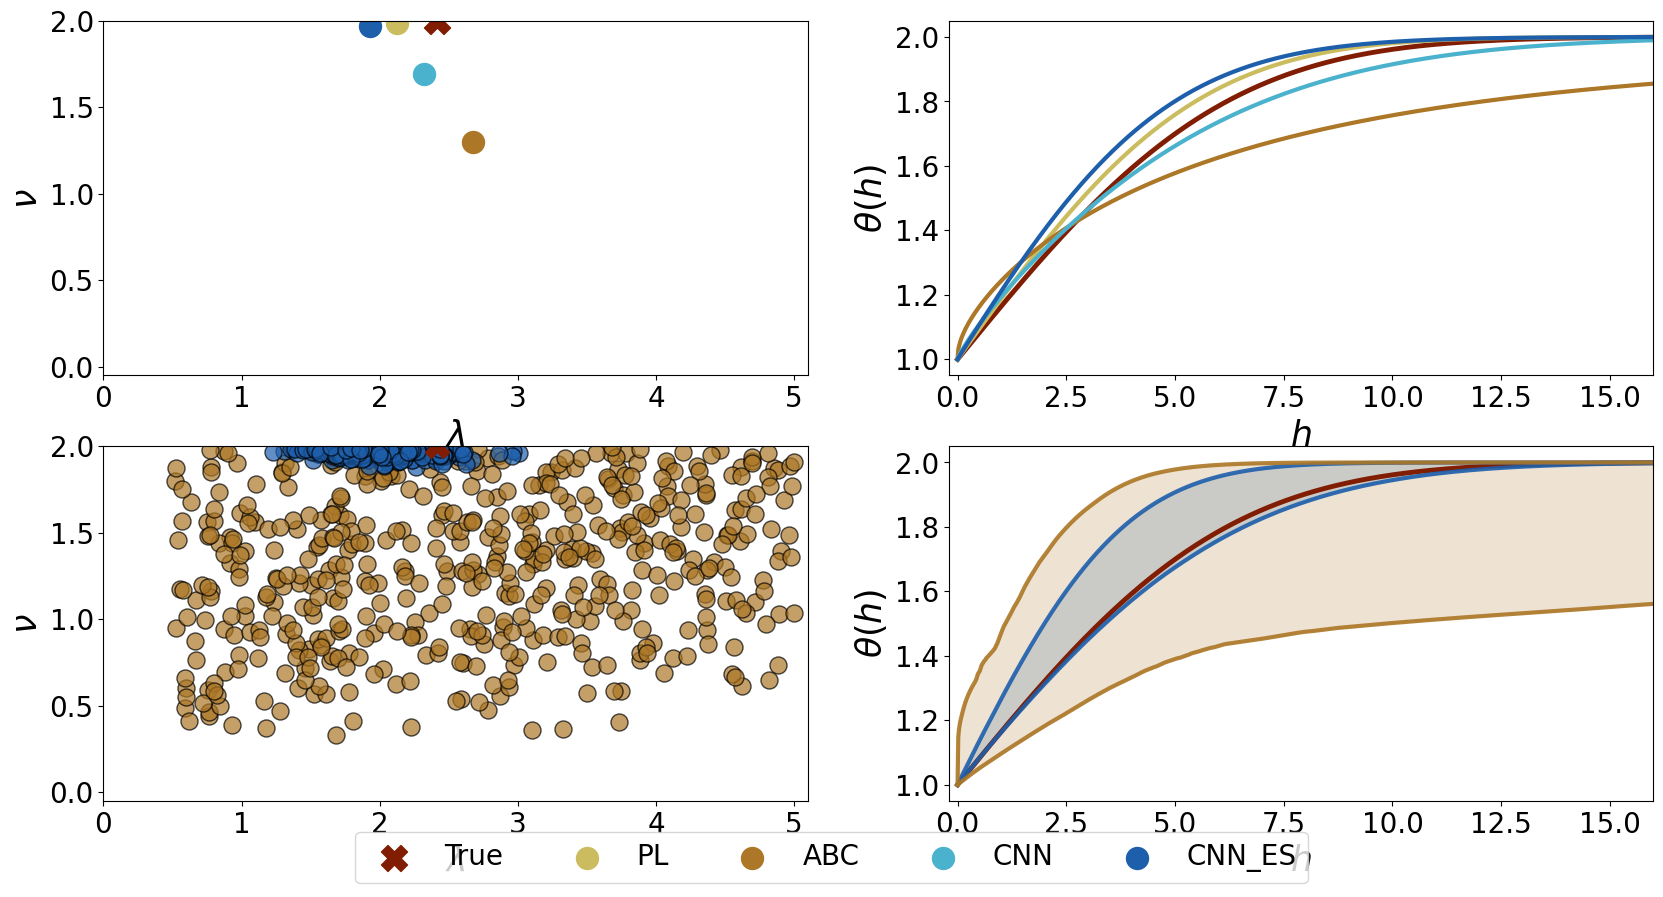

In [20]:
# Brown 49 Powexp 3
sample = np.random.randint(0,250)
model = "brown"

h = np.linspace(0,16,1000)
fig, axs = plt.subplots(2, 2, figsize = (20,10))
axs = np.transpose(axs).ravel()

#Mean values
axs[0].scatter(x = true_parameters[sample,0], y = true_parameters[sample,1], marker = "X", s = 350, color = cmap(0.99))
axs[0].scatter(x = pl[sample,0], y = pl[sample,1], color = cmap(0.65), s = 250)
axs[0].scatter(x = abc_mean[sample,0], y = abc_mean[sample,1], color = cmap(0.8), s = 250)
axs[0].scatter(x = cnn[sample,0], y = cnn[sample,1], color = cmap(0.3), s = 250)
axs[0].scatter(x = cnn_es_mean[sample,0], y = cnn_es_mean[sample,1], color = cmap(0.1), s = 250)
axs[0].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[0].set_ylabel(r"$\nu$", fontsize = axsize)
axs[0].tick_params(axis='both', labelsize=ticksize)
axs[0].set_xlim([0,5.1])
axs[0].set_ylim([-0.05,2])


# Sample values
axs[1].scatter(x = abc[sample,0], y = abc[sample,1], alpha = 0.7, color = cmap(0.8), s = 150, edgecolors = "black")
axs[1].scatter(x = cnn_es[sample,0], y = cnn_es[sample,1], alpha = 0.7, color = cmap(0.1), s = 150, edgecolors = "black")
axs[1].scatter(x = true_parameters[sample,0], y = true_parameters[sample,1], marker = "X", s = 300, color = cmap(0.99))
axs[1].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[1].set_ylabel(r"$\nu$", fontsize = axsize)
axs[1].tick_params(axis='both', labelsize=ticksize)
axs[1].set_xlim([0,5.1])
axs[1].set_ylim([-0.05,2])


# Extremal coefficient
axs[2].plot(h, extremal_coefficient(h, model, true_parameters[sample,0], true_parameters[sample,1]), color = cmap(0.99), lw = 3.5)
axs[2].plot(h, extremal_coefficient(h, model, pl[sample,0], pl[sample,1]), color = cmap(0.65), lw = 3)
axs[2].plot(h, sample_extremal_coefficient(h, model, abc[sample,0], abc[sample,1]), color = cmap(0.8), lw = 3)
axs[2].plot(h, extremal_coefficient(h, model, cnn[sample,0], cnn[sample,1]), color = cmap(0.3), lw = 3)
axs[2].plot(h, sample_extremal_coefficient(h, model, cnn_es[sample,0], cnn_es[sample,1]), color = cmap(0.1), lw = 3)
axs[2].set_xlabel(r"$h$", fontsize = axsize)
axs[2].set_ylabel(r"$\theta(h)$", fontsize = axsize)
axs[2].tick_params(axis='both', labelsize=ticksize)
axs[2].set_xlim([-0.2,16])

# Extremal coefficient uncertainty
es_quantiles = np.quantile(sample_extremal_coefficient(h, model, cnn_es[sample,0], cnn_es[sample,1],  mean = False), q = [0.025,0.975], axis = 0)
abc_quantiles = np.quantile(sample_extremal_coefficient(h, model, abc[sample,0], abc[sample,1],  mean = False), q = [0.025,0.975], axis = 0)

axs[3].plot(h, extremal_coefficient(h, model, true_parameters[sample,0], true_parameters[sample,1]), color = cmap(0.99), lw = 3.5)
axs[3].plot(h, es_quantiles[0], color = cmap(0.1), lw = 3, alpha = .9)
axs[3].plot(h, es_quantiles[1], color = cmap(0.1), lw = 3, alpha = .9)
axs[3].fill_between(h, es_quantiles[0], es_quantiles[1],  color = cmap(0.1), alpha=.2)

axs[3].plot(h, abc_quantiles[0], color = cmap(0.8), lw = 3, alpha = .9)
axs[3].plot(h, abc_quantiles[1], color = cmap(0.8), lw = 3, alpha = .9)
axs[3].fill_between(h, abc_quantiles[0], abc_quantiles[1], color = cmap(0.8), alpha=.2)
axs[3].set_xlabel(r"$h$", fontsize = axsize)
axs[3].set_ylabel(r"$\theta(h)$", fontsize = axsize)
axs[3].tick_params(axis='both', labelsize=ticksize)
axs[3].set_xlim([-0.2,16])


# Legend
fig.subplots_adjust(bottom=0.1)
fig.legend(labels = ["True", "PL", "ABC", "CNN", "CNN_ES"], loc='lower center', ncol = 5, fontsize = legendsize)
